# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

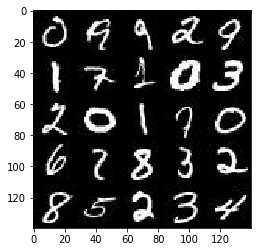

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

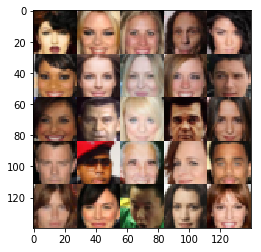

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # now is 14*14*64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # now is 7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # now is 4*4*256
        
        # flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28*28*128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28*28* out_channel_dim
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)*(1 - smooth)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)*(1 - smooth)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    out_channel_dim = image_channels
    
    input_real, input_z, lrate = model_inputs(image_width,image_height,image_channels,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                
                if steps %10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 3.1887
Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 3.5260
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 3.4944
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 2.6539
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 7.7326
Epoch 1/2... Discriminator Loss: 0.4578... Generator Loss: 2.3500
Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 4.2278
Epoch 1/2... Discriminator Loss: 1.7194... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.6873... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.7726


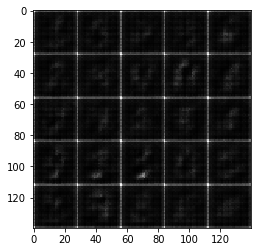

Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 1.0796
Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 1.0181
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 1.1283
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 1.6377
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.3250


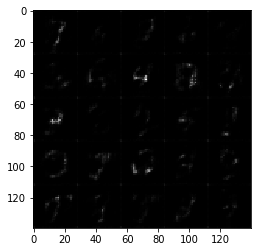

Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 2.1988
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.8988
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 1.2501
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 1.9943


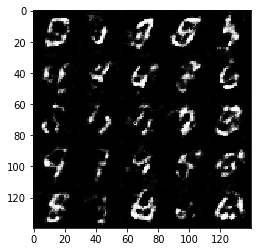

Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.4755
Epoch 1/2... Discriminator Loss: 0.9527... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 2.1268
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 1.6841
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 1.3590
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.6989


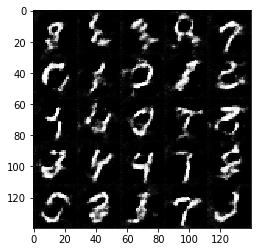

Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 1.7094
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 1.4905
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 1.2707
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.8561


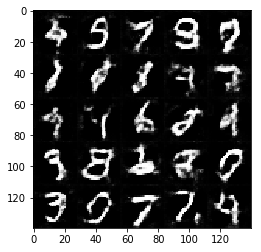

Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 1.2094... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 1.7655


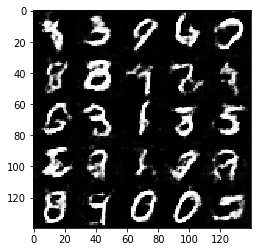

Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 1.3909
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 1.8911
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.9953
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 1.0893


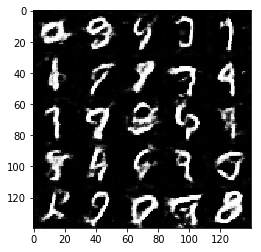

Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 1.5384
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.3022
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 1.1907
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 1.6950
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 1.4116


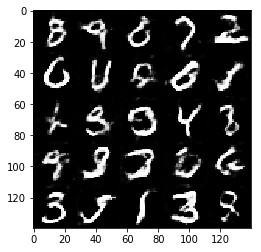

Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.4482
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 2.3325... Generator Loss: 3.4117
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.9887
Epoch 2/2... Discriminator Loss: 0.9201... Generator Loss: 1.0892


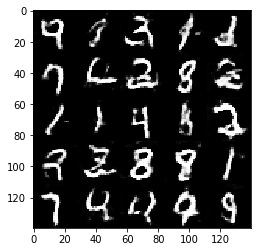

Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.0925
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.1513
Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 0.9930


In [21]:
batch_size = 128
z_dim =100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 2.1313
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.3742
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 3.0870
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 2.5236
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6621


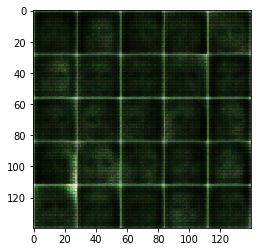

Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 2.7685
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.0244


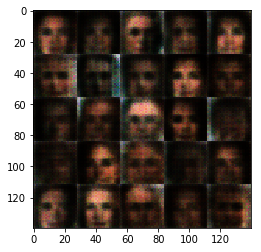

Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.3171
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 4.3808
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 4.9711


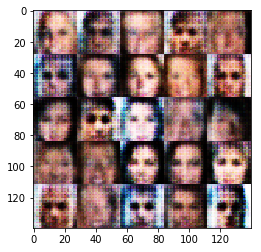

Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.6402
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 4.2936
Epoch 1/1... Discriminator Loss: 2.5171... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.0273
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.6154
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.5271


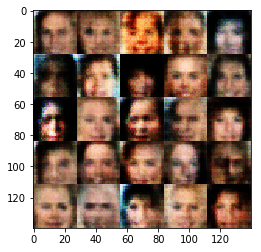

Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 3.0164
Epoch 1/1... Discriminator Loss: 1.8695... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 2.1993
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.7995... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 2.9127
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.0876


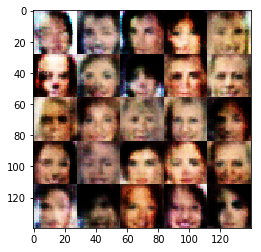

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 2.4092
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 3.7208
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 2.0146


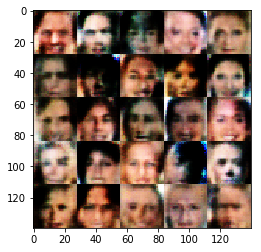

Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 4.8646
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 2.0746
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 2.9936
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.3450


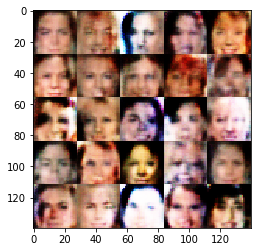

Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 3.5628
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 2.6750
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 3.4702
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.5395
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 2.3464


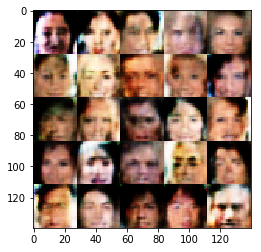

Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.8514
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 4.4297
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 2.3436
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 4.8587
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 2.3815
Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 2.6064
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 2.7258
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.9151


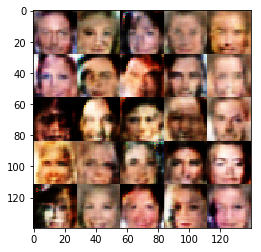

Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 2.3669
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.6228
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.8654
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 3.5517
Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 2.7843


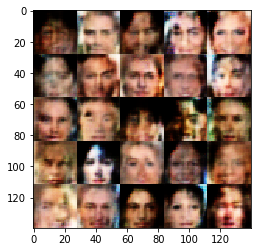

Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 3.4512
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.1884
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 3.1854
Epoch 1/1... Discriminator Loss: 1.9022... Generator Loss: 3.7256
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.7557
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 4.4661
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.1687
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 2.4199
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 2.8981


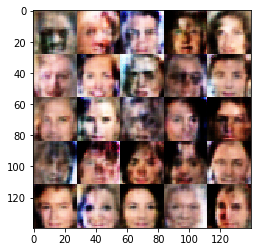

Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 2.0839
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 2.2258
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 2.3608
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 3.1970
Epoch 1/1... Discriminator Loss: 2.6789... Generator Loss: 2.4818
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.5520


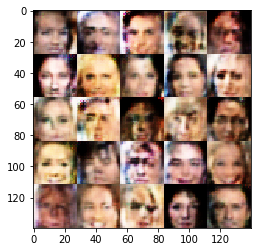

Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 2.1371
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.2906
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.1676
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 2.3173
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.6737
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.4741


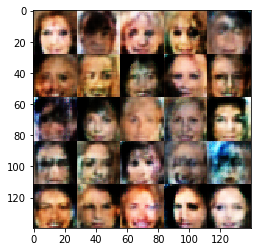

Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.7644
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.4366
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 3.1508
Epoch 1/1... Discriminator Loss: 2.5106... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.8957
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.6106


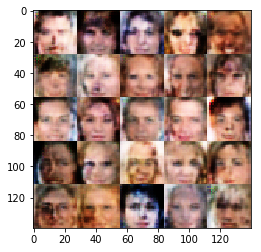

Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.8868
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.0211
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 2.6251
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 2.3792
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 2.5511
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 4.0541
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 1.9838
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.9068
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 3.0011


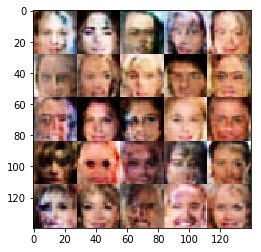

Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 4.4149
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 4.1194
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 2.3144
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 2.5257


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.